# NSMC 네이버 영화리뷰 감성분석

- - -

> **진행순서**

    1. 영화리뷰데이터 EDA  
        - 데이터 개수
        - 라벨 비율 확인
        - 평균 문장 길이 및 문장 길이 히스토그램

    2. 전처리 데이터클리닝(data cleaning)
        - 정규표현식을 이용하여 한국어가 아닌 글자 제외
        - 중복데이터 삭제
        - 결측데이터 살제
        - 불용어 정의 및 제거(토큰화 한 후 불용어 제거)
    
    3. 토큰화
        - 한국어 형태소분석기 비교
            okt
            mecab
            komoran
            kkma 
            hannanum  
        - 토큰화 -> okt  

    4. Text Embedding -> Word2Vec
        - 희귀단어 정의
        - 임베딩 벡터 학습 및 정의
        - 빈 셈플 제거
        - 패딩(Padding)  
        
    5. LSTM 모델학습   
        - with Word2Vec
        - without Word2Vec
- - -

### 필요 라이브러리 설치 및 분석 환경 정보

**[가상환경]**  
local에서 진행할 경우 아래 명령어로 가상환경 실행  
```conda activate nsmc  ```

**[사용한 환경 정보]**  
파이썬 버전 : 3.7.13  
tensorflow 버전 : 2.10

In [44]:
import os 

# EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import json
from matplotlib import font_manager, rc
%matplotlib inline
import warnings
warnings.filterwarnings( 'ignore' )

# 한글폰트 불러오기
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import pickle
import re
import string

# preprocessing
import konlpy
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
import gensim

# modeling-ML
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

# modeling-DL
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM

## 데이터 EDA

In [3]:
# 네이버 영화리뷰 데이터 불러오기
train = pd.read_table(r"data\nsmc\ratings_train.txt")
test = pd.read_table(r"data\nsmc\ratings_test.txt")
train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 데이터 개수 확인

In [4]:
# 데이터 개수
print(train.shape)
print(test.shape)

(150000, 3)
(50000, 3)


### 라벨 비율 확인

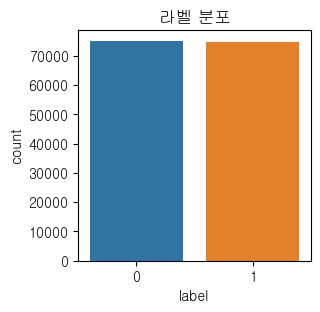

In [5]:
# 라벨의 비율 확인
# 0 : 부정, 1 : 긍정
plt.figure(figsize=(3,3))
sns.countplot(x='label',data=train)
plt.title('라벨 분포')
plt.show()

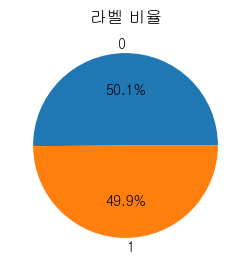

In [6]:
# 라벨 비율 확인
labels = ['0','1']
plt.figure(figsize=(3,3))
plt.title('라벨 비율')
plt.pie(train['label'].value_counts(), labels=labels, autopct='%.1f%%')
plt.show()

### 평균 리뷰 길이 및 리뷰길이 히스토그램

리뷰의 최대 길이 : 146
리뷰의 평균 길이 : 35.203453333333336


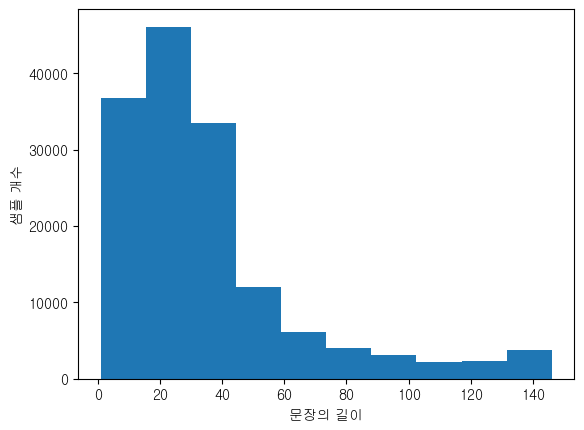

In [7]:
print('리뷰의 최대 길이 :', max([len(str(review)) for review in train['document']]))
print('리뷰의 평균 길이 :', np.mean([len(str(review)) for review in train['document']]))
plt.hist([len(str(review)) for review in train['document']])
plt.xlabel('문장의 길이')
plt.ylabel('샘플 개수')
plt.show()

리뷰 길이의 최대 값은 146글자이며 평균은 35글자이다.  
그러나 이후 전처리과정과 토크나이징을 처리를 한 후에 다시 확인해 볼 필요 있음.

## 전처리(Preprocessing) , 데이터클리닝

전처리 순서 

    1. 정규표현식을 이용하여 한국어를 제외한 글자 제거
    2. 중복데이터 제거
        1번 정제과정에서 데이터가 정제되면서 중복데이터가 생길 수 있기 때문에 정규표현식 정제를 먼저 해주었습니다.
    3. 결측데이터 제거
        2번 중복데이터 제거 후 공백 " " 데이터를 Nan데이터로 변환한 후 결측데이터를 제거 하였습니다.
    4. 불용어 정의 및 제거(토큰화 한 후 불용어 제거)

### 1. 정규표현식 이용하여 한국어를 제외한 글자 제거

In [8]:
train['document'] = train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test['document'] = test['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

### 결측값 및 중복데이터 확인

In [9]:
# 결측값 확인
print('train data 결측값 수:', train['document'].isnull().sum())
print('test data 결측값 수:', test['document'].isnull().sum()) 

train data 결측값 수: 5
test data 결측값 수: 3


In [10]:
# 중복데이터 확인-train
print('중복데이터 개수(train) :',train[train['document'].duplicated()].shape[0])
train[train['document'].duplicated()].head()

중복데이터 개수(train) : 6317


,id,document,label
412,9509970,,1
593,6478189,,0
638,9364602,,0
668,1600635,,0
1058,5890638,,0


In [11]:
# 중복데이터 확인 - test
print('중복데이터 개수(test) :',test[test['document'].duplicated()].shape[0])
test[test['document'].duplicated()].head()

중복데이터 개수(test) : 1581


,id,document,label
116,6910486,,1
254,4976468,,0
468,7517102,,0
504,2096424,,0
558,171480,,1


### 2. 중복 데이터 제거


In [12]:
train.drop_duplicates(subset=['document'], inplace=True)
test.drop_duplicates(subset=['document'], inplace=True)

print('중복데이터 제거 후 데이터 수(train) :',train.shape[0])
print('중복데이터 제거 후 데이터 수(test) :',test.shape[0])

중복데이터 제거 후 데이터 수(train) : 143683
중복데이터 제거 후 데이터 수(test) : 48419


### 3. 결측값 제거

In [13]:
train['document'] = train['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train['document'].replace('', np.nan, inplace=True)
test['document'] = test['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
test['document'].replace('', np.nan, inplace=True)

print('결측값 수(train) :', train['document'].isnull().sum())
print('결측값 수(test) :',test['document'].isnull().sum())

결측값 수(train) : 23
결측값 수(test) : 16


In [14]:
# 결측값 제거
train.dropna(how='any', inplace=True)
test.dropna(how='any', inplace=True)

print(train['document'].isnull().sum())
print(test['document'].isnull().sum())

0
0


In [15]:
# 총 데이터 수
print('train :', train.shape[0])
print('test :', test.shape[0])

train : 143660
test : 48403


### 4. 불용어 정의 및 제거

https://github.com/stopwords-iso/stopwords-ko  
여기에 한국어 불용어에 대해서 정리를 해놓은 파일이 있다. 

여기에서 정의해 놓은 불용어를 사용하려 했으나 사용하지 않기로 하였음.

그 이유는 리뷰데이터는 데이터 하나하나의 길이가 길지 않고 중요한 단어 하나 혹은 접속사나 조사에 의미를 담고 평가를 내리는 경우가 많다. 그러나 이 불용어 리스트에는 '메스껍다','결론을 낼 수 있다' 와 같이 영화에 대한 평가를 내리는데 중요한 단어, 표현들이 있기 때문에 사용하지 않기로 하였음.

대신에 영화리뷰 데이터이므로 직접 보면서 불용어 리스트들을 정리해보았다. 이 부분은 개인적인 생각이기 때문에 보는 사람의 관점에 따라 의견이 다를수 있을것이다.

실제 불용어 제거는 후에 토큰화 작업을 한 뒤에 할 계획이다. 지금은 띄어쓰기도 잘 되어있지 않은 데이터가 많고 오타도 많아 한국어 형태소분석기의 힘을 빌려 데이터를 더 정제한 뒤에 불용어를 제거하는 방식으로 진행해보겠다.

In [16]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','아니','및','아','혹시','흠']

## 토큰화

### 한국어 형태소분석기 비교

오픈된 한국어 형태소 분석기 중에서 5가지를 선택하였고 이 중에서 형태소 분석기를 비교해서 선택하겠다.
1. OKT
2. mecab
3. komoran
4. kkma
5. hannanum

모두 konlpy 라이브러리에서 사용 가능하며   
특별히 mecab은 윈도우에서 사용하려면 별도의 설치작업이 필요하다. 

분석하려는 텍스트 데이터가 영화 리뷰이므로 이 데이터에 가장 잘 맞는 형태소 분석기를 선택하는 것도 중요하다. 띄어쓰기, 맞춤법, 은어들이 포함되어 있는 텍스트 이므로 이를 잘 분석해주는 형태소 분석기를 찾아보도록 하겠다.

In [17]:
# 토큰화 함수 정의

okt = konlpy.tag.Okt()
mecab = konlpy.tag.Mecab('C:\mecab\mecab-ko-dic')
komoran = konlpy.tag.Komoran()
kkma = konlpy.tag.Kkma()
hannanum = konlpy.tag.Hannanum()

tokenizer_list = [okt, mecab, komoran, kkma, hannanum]

In [18]:
# 정상적인 데이터
test1 = '난 정말 무서웠는데 스토리도 나름 괜찮았어요.'

# 띄어쓰기가 제대로 되어 있지 않은 데이터
test2 = '아진짜계속빵터졌음ㅋㅋ아너무재밌어'

# 띄어쓰기 + 맞춤법이 제대로 되어 있지 않은 데이터
test3 = '너무재밓었다그래서보는것을추천한다'

# 띄어쓰기 + 맞춤법이 제대로 되어 있지 않은 데이터 2
test4 = '알바넘티난다완전말투다비슷함짱웃경진짜이런게있구나 잼써도알바땜에기분나빠서안봄'

In [19]:
# 난 정말 무서웠는데 스토리도 나름 괜찮았어요.
for tokenizer in tokenizer_list:
    print('형태소분석기 : {}\n'.format(str(tokenizer.__class__)[20:-2]),tokenizer.morphs(test1),'\n')

형태소분석기 : okt.Okt
 ['난', '정말', '무서웠는데', '스토리', '도', '나름', '괜찮았어요', '.'] 

형태소분석기 : mecab.Mecab
 ['난', '정말', '무서웠', '는데', '스토리', '도', '나름', '괜찮', '았', '어요', '.'] 

형태소분석기 : komoran.Komoran
 ['나', 'ㄴ', '정말', '무섭', '었', '는데', '스토리', '도', '나름', '괜찮', '았', '어요', '.'] 

형태소분석기 : kkma.Kkma
 ['나', '는', '정말', '무섭', '었', '는데', '스토리', '도', '나름', '괜찮', '았', '어요', '.'] 

형태소분석기 : hannanum.Hannanum
 ['나', 'ㄴ', '정말', '무섭', '었는데', '스토리', '도', '나름', '괜찮', '아아', '요', '.'] 



In [20]:
# 아진짜계속빵터졌음ㅋㅋ아너무재밌어
for tokenizer in tokenizer_list:
    print('형태소분석기 : {}\n'.format(str(tokenizer.__class__)[20:-2]),tokenizer.morphs(test2),'\n')

형태소분석기 : okt.Okt
 ['아', '진짜', '계속', '빵터졌음', 'ㅋㅋ', '아', '너무', '재밌어'] 

형태소분석기 : mecab.Mecab
 ['아', '진짜', '계속', '빵', '터졌', '음', 'ㅋㅋ', '아', '너무', '재밌', '어'] 

형태소분석기 : komoran.Komoran
 ['아진짜계속빵터졌음ㅋㅋ아너무재밌어'] 

형태소분석기 : kkma.Kkma
 ['아', '아', '진짜', '계속', '빵', '터지', '었', '음', 'ㅋㅋ', '아', '아', '너무', '재밌', '어'] 

형태소분석기 : hannanum.Hannanum
 ['아진짜계속빵터졌음ㅋㅋ아너무재밌어'] 



In [21]:
# 너무재밓었다그래서보는것을추천한다
for tokenizer in tokenizer_list:
    print('형태소분석기 : {}\n'.format(str(tokenizer.__class__)[20:-2]),tokenizer.morphs(test3),'\n')

형태소분석기 : okt.Okt
 ['너', '무재', '밓었', '다그', '래서', '보는것을', '추천', '한', '다'] 

형태소분석기 : mecab.Mecab
 ['너무', '재', '밓었다그래서보는것을추천한다'] 

형태소분석기 : komoran.Komoran
 ['너무재밓었다그래서보는것을추천한다'] 

형태소분석기 : kkma.Kkma
 ['너무', '재', '밓', '어', '었', '다', '그래서', '보', '는', '것', '을', '추천', '하', 'ㄴ다'] 

형태소분석기 : hannanum.Hannanum
 ['너무재밓었다그래서보는것을추천한다'] 



In [22]:
# 알바넘티난다완전말투다비슷함짱웃경진짜이런게있구나 잼써도알바땜에기분나빠서안봄
for tokenizer in tokenizer_list:
    print('형태소분석기 : {}\n'.format(str(tokenizer.__class__)[20:-2]),tokenizer.morphs(test4),'\n')

형태소분석기 : okt.Okt
 ['알바', '넘', '티', '난', '다완', '전', '말투', '다', '비슷함', '짱', '웃', '경', '진짜', '이런게', '있구나', '잼', '써도', '알바', '땜', '에', '기분', '나빠', '서안', '봄'] 

형태소분석기 : mecab.Mecab
 ['알', '바', '넘', '티', '난다', '완전', '말투', '다비', '슷함짱웃경진짜이런게있구나', '잼', '써도', '알', '바', '땜', '에', '기분', '나빠', '서안', '봄'] 

형태소분석기 : komoran.Komoran
 ['알바', '넘', '티나', 'ㄴ', '다완', '전', '말투', '다', '비슷', '하', 'ㅁ', '짱', '웃', '경', '진짜', '이렇', 'ㄴ', '게', '있', '구나', '재', 'ㅁ', '쓰', '어', '도', '알바', '땜', '에', '기분', '나쁘', '아서', '알', 'ㄴ', '봄'] 

형태소분석기 : kkma.Kkma
 ['알바', '넘', '티나', 'ㄴ다', '완전', '말투', '다', '비슷', '하', 'ㅁ', '짱웃', '경진', '짜', '아', '이렇', 'ㄴ', '것', '이', '있', '구', '나', '잼', '쓰', '어도', '알바', '땜', '에', '기분', '나쁘', '아서', '안', '봄'] 

형태소분석기 : hannanum.Hannanum
 ['알바넘티난다완전말투다비슷함짱웃경진짜이런게있구', '나', '잼써도알바땜에기분나빠서안봄'] 



**<비교결과 및 형태소분석기 선정>**  


여러가지 케이스로 형태소분석기들을 시험해 본 결과 **okt**와 **kkma**가 영화리뷰 데이터에는 적합한 것 같다.  
띄어쓰기나 오타 및 맞춤법 오류를 다른 형태소분석기보다 잘 잡아내는 것을 확인할 수 있다.

이 중에서 나는 **okt**를 사용하려 한다.

그 이유는 속도에 있다.
kkma가 너무 느리다.  
konlpy 공식 홈페이지에 가면 형태소분석기 간 성능비교를 한 표가 있는데 이때 kkma는 속도가 다른 모델에 비해 너무 느린 것을 확인할 수 있었다.

<img src="https://konlpy.org/ko/v0.4.3/_images/time.png" width="500">    

https://konlpy.org/ko/v0.4.3/_images/time.png


또 okt는 과거 트위터 형태소 분석기에서 발전한 모델이라고 한다.   
트위터도 소셜텍스트이기 때문에 영화리뷰같은 오타, 띄어쓰기, 맞춤법이 잘 정제되지 않은 텍스트를 잘 분석할 수 있는 것 같다.

### 토큰화(Tokenizing) - okt

- 한국어 형태소 분석기 okt.morphs를 이용한 토큰화 


	ex - 	[
		"더빙",
		"진짜",
		"짜증나네요",
		"목소리"
	]

	
- 토큰화 한 하면서 동시에 불용어 제거

In [23]:
# stem 옵션은 아래 결과와 같이 일정 수준의 정규화를 수행해준다.
# 짜증나네요 -> 짜증나다.
okt.morphs('더빙 진짜 짜증나네요 목소리', stem=True)

['더빙', '진짜', '짜증나다', '목소리']

In [24]:
# okt - morphs
if os.path.exists('tokenized_train_text_okt_wopos.json'):
    print("load")
    with open('tokenized_train_text_okt_wopos.json', encoding='utf-8') as f:
        X_train = json.load(f)
else:
    X_train = [[token for token in okt.morphs(doc, stem=True) if not token in stopwords] for doc in train['document']]
    with open('tokenized_train_text_okt_wopos.json', 'w', encoding='utf-8') as f:
        json.dump(X_train,  f, ensure_ascii=False, indent='\t')
print('tokenizing train data finished')

if os.path.exists('tokenized_test_text_okt_wopos.json'):
    print("load")
    with open('tokenized_test_text_okt_wopos.json', encoding='utf-8') as f:
        X_test = json.load(f)
else:
    X_test = [[token for token in okt.morphs(doc, stem=True) if not token in stopwords] for doc in test['document']]
    with open('tokenized_test_text_okt_wopos.json', 'w', encoding='utf-8') as f:
        json.dump(X_test, f, ensure_ascii=False, indent='\t')
print('tokenizing test data finished')


load
tokenizing train data finished
load
tokenizing test data finished


## Text Embedding -> Word2Vec

### 희귀단어 정의

Word2Vec로 단어들을 임베딩 하기전에 자주 쓰이지 않았던 단어들은 큰 의미가 없을것이라 생각하여 제외하는 과정을 추가하였습니다.

전체 문서에서 5번 미만 나온 단어를 희귀단어라고 정의했을 때

전체 단어 집합에서 희귀단어의 비율은 67% 
전체 문서에서 희귀단어가 등장하는 비율은 2.98% 이다.  

단어의 개수는 많이 줄어들겠지만  
영화 리뷰라는 한정적인 도메인에서 쓰이는 단어만 쓰인다는 부분과 
학습의 효율성을 고려하여 제외하도록 하였습니다. 

In [25]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
total_cnt = len(tokenizer.word_index) # 단어의 수
print('단어 개수 :',total_cnt)

단어 개수 : 43748


In [26]:
threshold = 5
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43748
등장 빈도가 4번 이하인 희귀 단어의 수: 29516
단어 집합에서 희귀 단어의 비율: 67.468227118954
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.9837862017793904


### Word2Vec 임베딩 벡터 학습 및 정의.

앞서 논의했듯 5개 미만으로 등장하는 희귀단어는 제외하기 위해서 min_count옵션을 5로 두고 학습하였습니다.

In [27]:
# word2vec 임베딩 벡터 만들기
w2vmodel_wopos = Word2Vec(sentences=X_train, size=300, window=5, min_count=5, iter=10)
print(w2vmodel_wopos.wv.vectors.shape,'\n')
print(w2vmodel_wopos.wv.most_similar('최민식'),'\n')
print(w2vmodel_wopos.wv.most_similar('재미없다'),'\n')
print(w2vmodel_wopos.wv.most_similar('히어로'),'\n')
vocab_size = w2vmodel_wopos.wv.vectors.shape[0]+1
vocab_size

(14232, 300) 

[('한석규', 0.7892199754714966), ('안성기', 0.7553542852401733), ('설경구', 0.7431440949440002), ('워싱턴', 0.7188030481338501), ('베이컨', 0.718478798866272), ('류덕환', 0.71726393699646), ('이정재', 0.7093364596366882), ('스트립', 0.7090847492218018), ('송강호', 0.7044193744659424), ('채민서', 0.7038134336471558)] 

[('졸리다', 0.5597388744354248), ('시시하다', 0.5430570244789124), ('짜증나다', 0.5300896167755127), ('심각하다', 0.5012387037277222), ('화나다', 0.48973187804222107), ('노잼', 0.472282350063324), ('졸다', 0.4663607180118561), ('참고', 0.463992178440094), ('유치하다', 0.4544386863708496), ('지루하다', 0.4529646635055542)] 

[('슬래셔', 0.7835956811904907), ('무협', 0.7697320580482483), ('괴수', 0.7579325437545776), ('느와르', 0.7369807958602905), ('뱀파이어', 0.735053300857544), ('갱스터', 0.7316623330116272), ('원조', 0.7287888526916504), ('물', 0.7216478586196899), ('로코', 0.7207579016685486), ('물의', 0.717576265335083)] 



14233

In [28]:
embedding_matrix = np.zeros((vocab_size, 300))
print(np.shape(embedding_matrix)) # (14233, 300)

def get_vectors(w2v_model, word):
    if word in w2v_model:
        return w2v_model[word]
    else:
        None

# # 단어 집합 크기의 행과 300개의 열을 가지는 행렬 생성. 값은 전부 0으로 채워진다.
for word, i in tokenizer.word_index.items():
    temp = get_vectors(w2vmodel_wopos, word)
    if temp is not None:
        embedding_matrix[i] = temp


(14233, 300)


임베딩벡터의 전체 단어 개수는 14233개가 나왔습니다.  

이제 훈련데이터를 임베딩벡터의 단어 개수만큼 정수 인덱싱 할 수 있도록 토크나이저 객체를 다시 설정합니다.

In [29]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
# 텍스트 데이터 인코딩작업
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
print(X_train[0])
print(X_test[0])

[454, 16, 261, 658]
[768, 87]


In [30]:
y_train = np.array(train['label'])
y_test = np.array(test['label'])

### 빈 셈플 제거

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 희귀단어로만 이루어진 데이터가 삭제되었을 수도 있습니다.

삭제되었다면 아무런 텍스트정보가 없는 빈 데이터가 될 것이고

라벨이 붙어있다 하더라도 의미가 없으므로 제거합니다.

In [31]:
# 단어개수(vocab size)를 줄이면서 생긴 빈 샘플의 수
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
print(len(drop_train))

327


In [32]:
# 빈 셈플 제거
print(len(X_train))
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

143660
143333
143333


### 패딩(Padding)

리뷰마다 단어의 개수가 다르다는 것은 당연한 사실.  
그러나 lstm의 모델에 input으로 넣기 위해서는 모든 데이터들의 차원을 통일시킬 필요가 있다.  
이를 위해서 사용하는 기법이 패딩이고  
얼만큼의 리뷰길이가 적절한지 알아보자  

리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.773352961285957


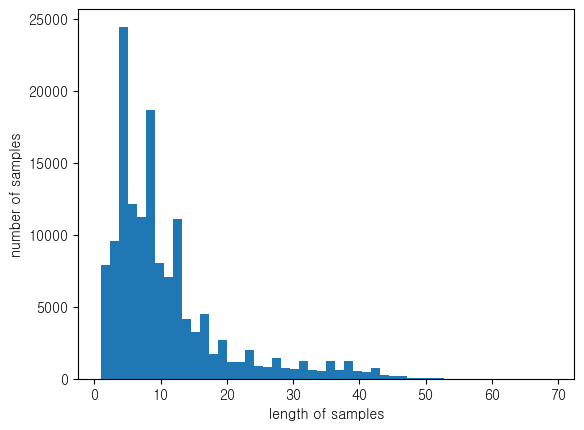

In [33]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [34]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 30
below_threshold_len(max_len, X_train)


전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.43533589612998


In [35]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
print(X_train[0])
print(X_test[0])


[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0 454  16 261 658]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0 768  87]


전체 길이가 30개 이하인 리뷰가 약 95%정도 된다.  

따라서 모든 리뷰길이를 30으로 통일시켜 패딩작업을 하였습니다.

## LSTM 모델 학습

### LSTM 모델 with Word2Vec

In [36]:
# 하이퍼 파라미터 설정
batch_size = 128
EPOCHS = 15

checkpoint_path = 'results/lstm_w2v.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                save_weights_only=True,
                                verbose=1)# Train the model with the new callback

earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, verbose=1)

In [37]:
# Modeling - lstm with word2vec
model = Sequential()
model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_len, trainable=False)) # weights를 미리 학습해둔 embedding_matrix로 설정하고 trainable옵션은 False로 하여 학습된 벡터를 사용하도록 한다.
model.add(LSTM(128, dropout=0.2))
model.add(Dense(64, activation = 'tanh'))
model.add(Dense(1, activation = 'sigmoid'))
print(model.summary())

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 학습
history = model.fit(X_train, y_train, epochs=EPOCHS, callbacks=[earlystopper,cp_callback], batch_size=batch_size, validation_split=0.2)

# Model Test
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)

# Model Save
model.save('results/lstm_w2v.h5')

# score
print("Test Score: ", score)
print("Test Accuracy: ", acc)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 300)           4269900   
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,497,869
Trainable params: 227,969
Non-trainable params: 4,269,900
_________________________________________________________________
None
Epoch 1/15
893/896 [============================>.] - ETA: 0s - loss: 0.3848 - accuracy: 0.8237
Epoch 1: saving model to results\lstm_w2v.ckpt
896/896 [===============

In [43]:

# score
print("Test Score: ", score)
print("Test Accuracy: ", acc)

Test Score:  0.46160492300987244
Test Accuracy:  0.8427577018737793


### LSTM 모델 without word2Vec

In [38]:
# 하이퍼 파라미터 설정
batch_size = 128
EPOCHS = 15

checkpoint_path = 'results/lstm.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                save_weights_only=True,
                                verbose=1)# Train the model with the new callback

earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, verbose=1)

In [39]:
# Modeling - lstm without word2vec
model_wo_w2v = Sequential()
model_wo_w2v.add(Embedding(vocab_size, 300, input_length=max_len)) # keras에서 제공하는 embedding vector를 사용
model_wo_w2v.add(LSTM(128, dropout=0.2))
model_wo_w2v.add(Dense(64, activation = 'tanh'))
model_wo_w2v.add(Dense(1, activation = 'sigmoid'))
print(model_wo_w2v.summary())

# 모델 컴파일
model_wo_w2v.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 학습
history = model_wo_w2v.fit(X_train, y_train, epochs=EPOCHS, callbacks=[earlystopper,cp_callback], batch_size=batch_size, validation_split=0.2)

# Model Test
score, acc = model_wo_w2v.evaluate(X_test, y_test, batch_size=batch_size)

# Model Save
model_wo_w2v.save('results/lstm.h5')

# score
print("Test Score: ", score)
print("Test Accuracy: ", acc)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 300)           4269900   
                                                                 
 lstm_1 (LSTM)               (None, 128)               219648    
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,497,869
Trainable params: 4,497,869
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
893/896 [============================>.] - ETA: 0s - loss: 0.3881 - accuracy: 0.8235
Epoch 1: saving model to results\lstm.ckpt
896/896 [=======================

### 리뷰 예측해보기

In [40]:
def sentiment_predict(new_sentence,loaded_model):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    print(new_sentence)
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [45]:
print('LSTM 모델 with Word2Vec')
sentiment_predict('겁나 재밌었음. 다음에도 이 감독이 만든 영화는 무조건 챙겨본다 진짜',model)
sentiment_predict('이딴 영화를 왜 만드는거임 정말?',model)

LSTM 모델 with Word2Vec
['겁나다', '재밌다', '다음', '에도', '감독', '만들다', '영화', '무조건', '챙기다', '보다', '진짜']
1/1 [==============================] - 0s 19ms/step
98.20% 확률로 긍정 리뷰입니다.

['이딴', '영화', '왜', '만들다', '임', '정말']
1/1 [==============================] - 0s 18ms/step
99.73% 확률로 부정 리뷰입니다.



In [46]:
print('LSTM 모델 without Word2Vec')
sentiment_predict('겁나 재밌었음. 다음에도 이 감독이 만든 영화는 무조건 챙겨본다 진짜',model_wo_w2v)
sentiment_predict('이딴 영화를 왜 만드는거임 정말?',model_wo_w2v)

LSTM 모델 without Word2Vec
['겁나다', '재밌다', '다음', '에도', '감독', '만들다', '영화', '무조건', '챙기다', '보다', '진짜']
1/1 [==============================] - 0s 18ms/step
98.66% 확률로 긍정 리뷰입니다.

['이딴', '영화', '왜', '만들다', '임', '정말']
1/1 [==============================] - 0s 17ms/step
99.74% 확률로 부정 리뷰입니다.



## 결론

주변 단어까지도 같이 학습하고 관계를 내포할 수 있는 Word2Vec로 LSTM을 학습시키면 더 나은 성능을 보이지 않을까 예상하고 시작한 프로젝트였다.

word2vec 임베딩벡터를 사용한 것과 keras 임베딩 벡터를 사용한 두 모델을 비교해보았고 결과는 크게 다르지 않았다.